In [1]:
from bw_recipe_2016 import (
    WaterConsumption,
    get_biosphere_database, 
    extract_recipe,
)

In [2]:
biosphere = get_biosphere_database()

In [3]:
gw = WaterConsumption(None, biosphere)

In [4]:
gw.apply_strategies()

Applying strategy: match_single
Applied 1 strategies in 0.02 seconds


In [5]:
gw.data[0]

{'name': ('ReCiPe 2016', 'v1.1 (20180117)', 'Water consumption'),
 'unit': 'm3-eq.',
 'filename': 'ReCiPe2016_CFs_v1.1_20180117.xlsx',
 'description': '',
 'exchanges': [{'amount': 1,
   'name': 'Water',
   'categories': ('water',),
   'input': ('biosphere3', '2404b41a-2eed-4e9d-8ab6-783946fdf5d6')},
  {'amount': 1,
   'name': 'Water',
   'categories': ('water', 'fossil well'),
   'input': ('biosphere3', '2256a142-8242-4b4f-b9aa-a167803989ca')},
  {'amount': 1,
   'name': 'Water',
   'categories': ('water', 'ground-'),
   'input': ('biosphere3', '51254820-3456-4373-b7b4-056cf7b16e01')},
  {'amount': 1,
   'name': 'Water',
   'categories': ('water', 'ground-, long-term'),
   'input': ('biosphere3', '06d4812b-6937-4d64-8517-b69aabce3648')},
  {'amount': 1,
   'name': 'Water',
   'categories': ('water', 'surface water'),
   'input': ('biosphere3', 'db4566b1-bd88-427d-92da-2d25879063b9')},
  {'amount': 1,
   'name': 'Water, cooling, unspecified natural origin',
   'categories': ('natural r

In [7]:
gw.write_excel("land_transformation")

Wrote matching file to:
/Users/cmutel/Library/Application Support/Brightway3/default.c21f969b/output/lcia-matching-land_transformation.xlsx


In [6]:
gw.statistics()

1 methods
12 cfs
0 unlinked cfs


(1, 12, 0)

In [7]:
comp = gw.compare_to_previous()

In [8]:
[(key, len(comp[key])) for key in comp]

[('found', 7), ('missing', 0), ('reference', 1)]

Present in previous ReCiPe, missing here

In [10]:
comp['reference']

{'water'}

In [14]:
comp['found']

{'phosphate', 'phosphoric acid', 'phosphorus'}

In [9]:
sorted(comp['reference'].difference(comp['found']))

[]

In [ ]:
c['found']

In [ ]:
c['missing']

In [11]:
gw.write_methods(overwrite=True)

Wrote 1 LCIA methods with 12 characterization factors


In [12]:
gw.data[0]['name']

('ReCiPe 2016', 'v1.1 (20180117)', 'Water consumption')

# Compare to previous ReCiPe method

In [17]:
%matplotlib inline

In [18]:
import bw2data, bw2calc
import pyprind
import seaborn as sb
import numpy as np

In [19]:
keys = sorted([x.key for x in bw2data.Database("ecoinvent 3.6 cutoff")])

In [20]:
results_reference, results_2016 = [], []

In [21]:
lca = bw2calc.LCA({keys[0]: 1}, gw.previous_reference)
lca.lci()
lca.lcia()

In [22]:
reference_cm = lca.characterization_matrix.copy()

In [23]:
lca.switch_method(('ReCiPe 2016', 'v1.1 (20180117)', 'Water consumption'))

In [24]:
lca.characterization_matrix.sum(), reference_cm.sum()

(10.0, 5.0)

In [25]:
new_cm = lca.characterization_matrix.copy()

In [26]:
for key in pyprind.prog_bar(keys):
    lca.redo_lci({key: 1})
    results_reference.append((reference_cm * lca.inventory).sum())
    results_2016.append((new_cm * lca.inventory).sum())    

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:05:23


/Users/cmutel/miniconda3/envs/bw2dev/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


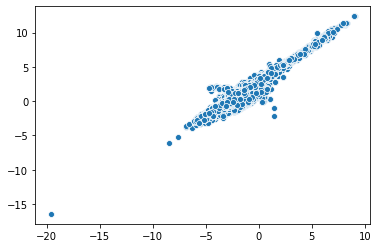

In [27]:
sb.scatterplot(np.log10(np.array(results_reference)), np.log10(np.array(results_2016)))

In [26]:
def masked_ratio(a, b):
    a, b = np.array(a), np.array(b)
    mask = (a != 0) * (b != 0)
    return a / b

/Users/cmutel/miniconda3/envs/bw2dev/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


OverflowError: cannot convert float infinity to integer

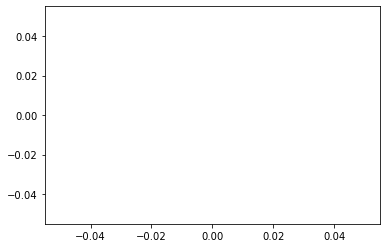

In [23]:
sb.distplot(masked_ratio(results_2016, results_reference))

In [24]:
def abnormal_ratio(a, b):
    if not a or not b:
        return
    ratio = abs(a / b)
    if 0.8 < ratio < 1.25:
        return
    return ratio

In [ ]:
exceptions = sorted([
    (abnormal_ratio(results_2016[i], results_reference[i]), bw2data.get_activity(key)) 
    for i, key in enumerate(keys) 
    if abnormal_ratio(results_2016[i], results_reference[i])
], reverse=True)

In [ ]:
len(exceptions)

In [ ]:
exceptions[:10]

In [ ]:
lca.redo_lci({exceptions[0][1]: 1})
lca.characterized_inventory = new_cm * lca.inventory